The multidimensional negative logarithm
$$
f(x) = - \sum_{i=1}^d \log (x_i)
$$
is defined on the positive orthant $\{x \in \mathbb{R}^d : x_i > 0 \text{ for all } i\}$. But we only consider it on the open hypercube $C = (10^{-3}, 10^{-1})^d$.
The gradient of $f$ is $\nabla f(x) = \left(-\frac{1}{x_1}, \dots, -\frac{1}{x_d}\right)$. So, the image $D = \nabla f(C)$ is the open hypercube $(-1000, -10)^d$.

It can easily be checked that $f^*$ is given by
$$
f^*(y) = - \sum_{i = 1}^d \log(-y_i) - d.
$$
We first attempt to learn it using a training set $\tilde{X}$ sampled **uniformly** from $C$.

Table \ref{tab:2} shows estimates of the $L^2$-approximation errors
$$
\|h_{\hat{\theta}} - f^*\|_{L^2(D , \nu)} \quad \text{and} \quad \|h_{\hat{\theta}} - f^*\|_{L^2(D , \text{Unif})},
$$
where $\nu$ is the push-forward of the uniform distribution on $C$ under $\nabla f$ and Unif is the uniform distribution on $D$. The training times are reported in hours, minutes, and seconds.


In [ ]:
# !pip install optax

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, lax
from jax.tree_util import tree_leaves
import optax
import matplotlib.pyplot as plt
import yaml
import os
import time
import sys
import json
from scipy.io import savemat
from tqdm import tqdm
from collections import namedtuple
from functools import partial
from typing import Callable, Any, List

# Flax library imports
from flax import linen as nn
from flax.training import train_state


In [ ]:
DPI = 100  # dpi = 300  # Set DPI for higher quality images


In [ ]:
base_path = "/content/drive/MyDrive/ETH/Convex_conjugates/experiments_with_ICNN_1"
 # results of experiments with ICNN that use nonlinear transform to ensure convexity
sys.path.append(base_path)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Primal QUADRATIC:
def square(x):
    return jnp.reshape(jnp.sum(x*x, -1), ())
# Dual:
square_star_true = lambda x: jnp.sum(x*x, -1) / 4

#########################
# Primal NEGATIVE-ENTROPY
def negative_entropy(x):
    return jnp.reshape(jnp.sum(x * jnp.log(x), -1), ())
# Dual
negative_entropy_star_true = lambda x: jnp.sum(jnp.exp(x - 1), -1)

##########################
# Primal Negative Logarithm
def negative_logarithm(x):
    return -jnp.sum(jnp.log(x), axis=-1)

# Dual of the Negative Logarithm
def negative_logarithm_star_true(y):
    return -jnp.sum(jnp.log(-y), axis=-1) - y.shape[-1]



In [ ]:
class NonNegativeDense(nn.Module):
    features: int
    use_bias: bool = True
    dtype: Any = None
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros
    pre_transform: Callable = jnp.square # Optional pre-transformation

    @nn.compact
    def __call__(self, inputs):
        kernel_shape = (inputs.shape[-1], self.features)
        kernel = self.param('kernel', self.kernel_init, kernel_shape)
        # if self.pre_transform:
        kernel = self.pre_transform(kernel)  # Apply pre-transformation if any
         # Squaring the kernel to ensure non-negative weights
        y = jnp.dot(inputs, kernel)
        if self.use_bias:
            bias = self.param('bias', self.bias_init, (self.features,))
            y += bias
        return y

class ConvexNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i == 0:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x

def gelu(x):
    return 0.5 * x * (1 + jax.scipy.special.erf(x / jnp.sqrt(2)))

class FCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu# nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i > -1:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x



class BNFCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu #nn.relu  # Default activation; can be customized

    @nn.compact
    def __call__(self, x, train: bool = True):
        for i, width in enumerate(self.layer_widths):
            x = nn.Dense(features=width)(x)
            if i < len(self.layer_widths) - 1:  # Apply BatchNorm and activation to all but the last layer
                x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
                x = self.activation(x)
        return x

# Configuration Parameters

- **experiment_name**: A string used to uniquely identify and track the experiment.
- **description**: A string describing the purpose or details of the experiment.
- **dim**: An integer representing the dimensionality of the input space.
- **layer_widths**: A list of integers specifying the number of units in each layer of the neural network.
- **num_epochs**: An integer representing the number of epochs to train the model.
- **batch_size**: An integer specifying the size of each training batch.
- **steps**: An integer representing the number of steps the model takes per batch, relevant when mini-batch optimization is used (i.e., when `use_grid` is False).
- **start**: A float or list of floats representing the start point(s) of the rectangular domain for the primal variables \( x \).
- **end**: A float or list of floats representing the end point(s) of the rectangular domain for the primal variables \( x \).
- **convrg_eps**: A float specifying the convergence threshold epsilon for stopping the training.
- **learning_rate**: A float representing the learning rate for the optimizer.
- **l2_regularization_coefficient**: A float for the L2 regularization term to prevent overfitting.
- **N_ae**: An integer specifying the number of epochs for pretraining an autoencoder, if applicable.
- **v_init_fn**: A callable function for initializing the parameters. For instance, it could be a function that generates random values within a certain range.
- **minval**: A float or list of floats indicating the minimum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **maxval**: A float or list of floats indicating the maximum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **y_func**: A callable function defining the behavior or computation of the dual variables \( y \).
- **y_func_star**: A callable function representing the true conjugate of \( y \).

## Domain Explanation

- **Primal Domain (`start` to `end`)**: The domain for the primal variables \( x \) is defined as \([start, end]^d\).
- **Dual Domain (`minval` to `maxval`)**: The domain for the dual variables \( y \) is defined as \([minval, maxval]^d\).

The correct transformation between the domains is $\nabla f: H \to K$  and $\nabla^{-1} f: K\to H$ realized below with approximate inverse mappings.

In [ ]:
LEARNING_RATE = 3e-4
ALPHA = 1e-8 #

Config = namedtuple("Config",
                    [
                     "experiment_name",        # Name of the experiment for tracking purposes
                     "description",            # Description of the experiment
                     "dim",                    # Dimensionality of the input space
                     "layer_widths",           # Widths of each layer in the neural network
                     "num_epochs",             # Number of epochs for training
                     "batch_size",             # Batch size for training
                     "steps",                  # Number of steps per batch (useful if use_grid is False)
                     "start",                  # Start point of the primal domain (rectangular domain start)
                     "end",                    # End point of the primal domain (rectangular domain end)
                     "convrg_eps",             # Convergence epsilon for stopping criterion
                    "ae_convrg_eps",             # Convergence epsilon for stopping criterion for ae
                     "learning_rate",          # Starting value of the learning rate for the optimizer
                     "learning_rate_ae",
                     "N_ae",                   # Number of epochs for autoencoder pretraining
                     "v_init_fn",              # Initialization function for the parameters
                     "minval",                 # Minimum value for the gradient domain (dual domain start)
                     "maxval",                 # Maximum value for the gradient domain (dual domain end)
                     "f_func",                 # Function definition for y (dual variables)
                     "f_func_star",             # True function conjugate for y
                     "train_sampling",         # use inverse sampling for train
                     "test_sampling"           # use inverse sampling for test
                    ])




In [ ]:
cfg = Config(
    experiment_name = "Negative_LOG_inverse_sampling_d=20",               # Name of the experiment for tracking purposes
    description = "Negative_LOG_inverse_sampling_d=20",        # Description of the experiment
    dim = 20,                               # Dimensionality of the input space
    layer_widths = (256, 256),           # Widths of each layer in the neural network
    num_epochs = 200000,                   # Number of epochs for training
    N_ae = 10000,                           # Number of epochs for autoencoder pretraining
    batch_size = 6200,                      # Batch size for training
    steps = 1,                              # Number of steps per batch (useful if use_grid is False)
    start = 0.001,                              # Start point of the primal domain (rectangular domain start point)
    end = 0.1,                                # End point of the primal domain (rectangular domain end point)
    minval = -1000,                             # Minimum value for the gradient domain (dual domain start)
    maxval = -10,                            # Maximum value for the gradient domain (dual domain end)
    ae_convrg_eps = 1e-9,                   #  Convergence epsilon for  ae stopping
    convrg_eps = 1e-5,                      # Convergence epsilon for stopping criterion
    learning_rate = 3e-3,                   # Learning rate for the optimizer
    learning_rate_ae  = 3e-4,
    v_init_fn = "V_INIT_Uniform",           # Initialization function for the parameters
    f_func = "negative_logarithm",            # Function definition for f (dual variables)
    f_func_star = "negative_logarithm_star_true", # True function conjugate for f*
    train_sampling = False, # use inverse sampling for train
    test_sampling = True, # use inverse sampling for test
)


# path_to_results_and_cfgs = os.path.join(base_path, "Experiment_test")

# # Path to the YAML file
# config_path = os.path.join(path_to_results_and_cfgs, 'config.yaml')

# # Save the config to the YAML file
# save_config_to_yaml(cfg, config_path)

In [ ]:
# Map the string names to the actual functions
function_mapping = {
    "square": square,
    "square_star_true" : square_star_true,
    "negative_entropy": negative_entropy,
    "negative_entropy_star_true" : negative_entropy_star_true,
    "negative_logarithm": negative_logarithm,
    "negative_logarithm_star_true": negative_logarithm_star_true,
    # Add other functions...
}




# Some saving/loading utils:

In [ ]:
def save_statistics(statistics, path_to_save, filename):
    # Convert JAX arrays to NumPy arrays, NumPy arrays to lists, and float32 to float
    serializable_stats = {}
    for k, v in statistics.items():
        if isinstance(v, (jnp.ndarray, np.ndarray)):
            v = jax.device_get(v).tolist()
        elif isinstance(v, np.float32):
            v = float(v)
        serializable_stats[k] = v

    print("Statistics:")
    for key, value in statistics.items():
        print(f"  {key}: {value}")

    full_path = os.path.join(path_to_save, filename)
    with open(full_path, 'w') as file:
        json.dump(serializable_stats, file)


In [ ]:
def save_config_to_yaml(config, path):
    with open(path, 'w') as file:
        yaml.dump(dict(config._asdict()), file)

# Some plotting/statistics utils:

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

def plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_loss_list, eval_loss_list):
    """
    Plots evaluation results and calculates residuals.

    Args:
        d (int): Dimensionality of the input space.
        eval_grad_f_x (array): Evaluated gradient values.
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        state (train_state.TrainState): Training state containing model parameters.
        const_val (float): Constant value for plotting higher dimensions.
        Loss (list): List of loss values over epochs.
    """

    dpi = DPI

    if d == 1:
        # Sort and plot for 1D
        eval_grad_f_x = np.squeeze(eval_grad_f_x)
        indices = np.argsort(eval_grad_f_x)
        eval_grad_f_x, preds = eval_grad_f_x[indices], preds.flatten()[indices].reshape(-1, 1)
        plt.figure(dpi=dpi)
        plt.plot(eval_grad_f_x, preds, lw=3, label='Predictions')
        plt.plot(eval_grad_f_x, vmap_f_star_true(eval_grad_f_x.reshape(-1, 1)), lw=3, label='True Conjugate')
        plt.xlabel('eval_grad_f_x')
        plt.ylabel('Function Values')
        plt.title('Sorted Points and Function Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate and print RMSE (residual)
        accuracy = 1 / np.sqrt(eval_grad_f_x.shape[0]) * jnp.linalg.norm(preds.reshape(-1, 1) - vmap_f_star_true(eval_grad_f_x).reshape(-1, 1))
        print("Residual:", accuracy)

    if d >= 2:
        # Scatter plot for first two components in 2D+
        start = jnp.min(eval_grad_f_x)
        end = jnp.max(eval_grad_f_x)
        plt.figure(dpi=dpi)
        plt.scatter(eval_grad_f_x[:, 0], eval_grad_f_x[:, 1], c='red', marker='o', s=30)  # Increased marker size
        plt.xlabel('Component 0 of eval_grad_f_x')
        plt.ylabel('Component 1 of eval_grad_f_x')
        plt.title('Scatter Plot of First Two Components of eval_grad_f_x')
        plt.grid(True)
        plt.show()

        def generate_1D_line_in_dD_space(axis, const_val, start, end, num_points=100, d=d):
            x = jnp.linspace(start, end, num_points)
            line_dD = jnp.ones((num_points, d)) * const_val
            line_dD = line_dD.at[:, axis].set(x)
            return line_dD

        def calculate_and_plot(axis, const_val):
            line_dD = generate_1D_line_in_dD_space(axis, const_val, start, end)
            f_x = state.apply_fn({'params': state.params}, line_dD)
            f_star_true_x = vmap_f_star_true(line_dD)

            # Calculate and print RMSE along the axis
            accuracy = 1 / np.sqrt(line_dD.shape[0]) * jnp.linalg.norm(f_x.reshape(-1, 1) - f_star_true_x.reshape(-1, 1))
            print("Residual along axis {} @ value = {}: {}".format(axis, const_val, accuracy))

            plt.figure(dpi=dpi)
            plt.plot(line_dD[:, axis], f_x, lw=3, label='f(x)')
            plt.plot(line_dD[:, axis], f_star_true_x, lw=3, label='True Conjugate')
            plt.title('Numerical and Analytical Conjugate along axis {}'.format(axis))
            plt.legend()
            plt.grid(True)
            plt.show()

        calculate_and_plot(axis=0, const_val=const_val)
        calculate_and_plot(axis=1, const_val=const_val)

    # Plot training loss over epochs
    plt.figure(dpi=100)
    plt.plot(train_loss_list, lw=3, label='Training Loss')
    plt.plot(eval_loss_list, lw=3, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def descriptive_statistics(data, name="Data"):
    """Returns descriptive statistics for the given data as a dictionary."""
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    minimum = np.min(data, axis=0)
    maximum = np.max(data, axis=0)
    shape = data.shape

    statistics = {
        "name": name,
        "shape": shape,
        "mean": mean,
        "std_dev": std_dev,
        "min": minimum,
        "max": maximum
    }

    return statistics


In [ ]:
def calculate_statistics(y, preds, vmap_f_star_true, cfg = cfg):
    """
    Calculate various statistics for evaluating the model's performance.

    Args:
        y (array): Batch of  values from gradiant space (from set D).
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        loss_value (float): The loss value from the model.

    Returns:
        acc (float): Root Mean Squared Error (RMSE) between predictions and true values, excluding infinities.
        max_acc (float): Maximum error between predictions and true values, excluding infinities.
        res (float): Square root of the loss value.
        mre (float): Mean Relative Error (MRE) between predictions and true values, excluding infinities.
    """
    # Calculate true conjugate values
    f_star_values = vmap_f_star_true(y)

    # Identify points where vmap_f_star_true gives infinity
    is_finite = jnp.isfinite(f_star_values)

    # Apply the mask to filter out infinite points
    finite_preds = preds[is_finite]
    finite_f_star_values = f_star_values[is_finite]

    # Reshape for calculation
    finite_preds_reshaped = finite_preds.reshape(-1, 1)
    finite_f_star_values_reshaped = finite_f_star_values.reshape(-1, 1)

    # Calculate RMSE excluding infinite points

    acc = 1 / np.sqrt(finite_preds_reshaped.shape[0]) * jnp.linalg.norm(finite_preds_reshaped - finite_f_star_values_reshaped)

    # Calculate maximum error excluding infinite points
    max_acc = jnp.max(jnp.abs(finite_preds_reshaped - finite_f_star_values_reshaped))

    # Calculate Mean Relative Error (MRE), avoiding division by zero
    relative_errors = jnp.where(finite_f_star_values_reshaped != 0,
                                jnp.abs((finite_preds_reshaped - finite_f_star_values_reshaped) / finite_f_star_values_reshaped),
                                0)
    mre = jnp.mean(relative_errors)

    # Calculate square root of the loss value

    # if loss_value is not None:
    #     res = np.sqrt(loss_value)
    # else:
    #     res = None  # Or handle the None case differently as need

    return acc, max_acc, mre


# RUN **SINGLE** EXPERIMENT

## JAX tricks:

We vmap all the funcitons for efficient computing.

In [ ]:
initial_key = jax.random.PRNGKey(0)

f = function_mapping[cfg.f_func]
f_star_true =  function_mapping[cfg.f_func_star]

# Wrapping the modified objective function with grad, jit, and vmap
grad_f_fn = jax.grad(f, argnums=0)
grad_f = jax.jit(grad_f_fn)

# Vectorization for processing batches of inputs "vmap_f_epsilon"
vmap_grad_f = vmap(grad_f, in_axes = 0)
vmap_f = vmap(f, in_axes = 0)
vmap_f_star_true = vmap(f_star_true, in_axes = 0)


In [ ]:
import jax
import jax.numpy as jnp

def x_uniform_sampling_generator(cfg, key, minval_x=None, maxval_x=None):
    minval_x = minval_x if minval_x is not None else cfg.start
    maxval_x = maxval_x if maxval_x is not None else cfg.end
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_x, maxval=maxval_x)
        yield U

def y_uniform_sampling_generator(cfg, key, minval_y=None, maxval_y=None):
    minval_y = minval_y if minval_y is not None else cfg.minval
    maxval_y = maxval_y if maxval_y is not None else cfg.maxval
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_y, maxval=maxval_y)
        yield U


# Replace the following placeholder functions with your actual implementations
def generate_y_samples_uniformly(key, batch_size, dim, minval = cfg.minval, maxval = cfg.maxval):
    return jax.random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)


def descriptive_statistics(x_samples, name="Data"):
    # Compute and return statistics
    return {
        'min': jnp.min(x_samples, axis=0),
        'max': jnp.max(x_samples, axis=0),
        'mean': jnp.mean(x_samples, axis=0),
        'std': jnp.std(x_samples, axis=0)
    }

# Initialize parameters and generators
# encoder_params = ae_state.params

key, subkey = jax.random.split(initial_key)

x_uniform_sampling =x_uniform_sampling_generator(cfg, key, minval_x= cfg.start, maxval_x=cfg.end) #  generate_x_samples_uniformly(cfg, key, minval_x=cfg.start, maxval_x=cfg.end)
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y= cfg.minval, maxval_y=cfg.maxval)

minval = cfg.minval  # = minval_y
maxval = cfg.maxval  # = maxval_y


## Train the model:

In [ ]:
x_uniform_sampling = x_uniform_sampling_generator(cfg, key, minval_x=cfg.start, maxval_x=cfg.end) # uniform in C
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y=cfg.minval, maxval_y=cfg.maxval) # uniform in D

In [ ]:
def get_next_batch(train_generator):
    # Define the range and resolution for each dimension
    start = cfg.start
    end = cfg.end
    num_points = 0 #cfg.n
    useGrid = False #cfg.use_grid

    if useGrid:
        # Create d-dimensional meshgrid
        meshgrids = [jnp.linspace(start, end, num_points) for _ in range(d)]
        meshgrid_dD = jnp.stack(jnp.meshgrid(*meshgrids), axis=-1)
        x = meshgrid_dD.reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))
    else:  # Use mini-batch approach
        x = next(train_generator).reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))

    return x, f_x, grad_f_x

In [ ]:
# def run_experiment(cfg):
# Initialize loss list to store the training loss values
Loss = []
d = cfg.dim
layer_sizes = cfg.layer_widths
initial_key = jax.random.PRNGKey(0)

# Function mappings
f = function_mapping[cfg.f_func]
f_star_true = function_mapping[cfg.f_func_star]

train_x = x_uniform_sampling
test_x =  x_uniform_sampling

test_y = y_uniform_sampling # sample from the target distribution nu
# test_y2 = get_next_batch(x_uniform_sampling)[2] # image of x with distibution mu (we will use test_x2 that let one generate the same + evaluate losses of the model)

# Initialize the model
# Dummy data
batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

# Model and optimizer setup
layer_widths = cfg.layer_widths
model = ConvexNN(activation=nn.softplus, layer_widths=layer_widths)# FCNN(activation=nn.softplus, layer_widths=layer_widths)#ConvexNN(activation=nn.softplus, layer_widths=layer_widths)

key = random.PRNGKey(0)
x_dummy = jnp.ones((1, d))
params = model.init(key, x_dummy)['params']

initial_learning_rate = 3e-2
min_learning_rate = 1e-9
lr_schedule = optax.exponential_decay(init_value=initial_learning_rate, transition_steps=1000, decay_rate=0.95, end_value=min_learning_rate, staircase=True)

# Define the gradient clipping transformation
grad_clip = optax.clip_by_global_norm(1.0)

# Combine the optimizer with gradient clipping
optimizer = optax.chain(
    grad_clip,
    optax.adam(learning_rate=lr_schedule)
)

# Training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

@jax.jit
def train_step(state, inputs_x, inputs_grad_f_x, targets):
    # Adjust the pure_loss_fn to include all necessary arguments
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss

    # Bind the additional arguments to loss_fn before differentiation
    loss_fn = partial(pure_loss_fn, inputs_x=inputs_x, inputs_grad_f_x=inputs_grad_f_x, targets=targets)
    grads = jax.grad(loss_fn, argnums=0)(state.params)
    new_state = state.apply_gradients(grads=grads)
    loss_value = loss_fn(state.params)  # Recompute loss after update for logging/monitoring
    return new_state, loss_value



# LOSS FOR PLOTTING PURPOSES:
# we do not use regularizers
def print_loss_fn(params, inputs_x, inputs_grad_f_x, targets, use_regularizer = False):
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss
    loss = pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets)
    return loss

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the timing and progress tracking
tic = time.time()
epoch = 0  # Initialize epoch counter
N = cfg.num_epochs  # Total number of epochs
# Initialize tqdm progress bar
pbar = tqdm(total=N, desc="Processing", position=0, leave=True)

converged = False

# Initialize variables to track the best RMSE and the corresponding epoch
best_rmse = float('inf')
best_epoch = 0

eval_loss_fn = print_loss_fn

# List to store statistics for each evaluation
statistics_list = []

# Lists to store losses for later analysis
train_losses = []
eval_losses = []

while epoch < N - 1:

    # Get the next batch of data
    batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

    current_lr = lr_schedule(epoch)

    for _ in range(cfg.steps):
        # Update the model using the training step function
        state, loss_value = train_step(state, batch_x, train_grad_f_x, train_y)
        pbar.update(1)

    # Increment the epoch counter after each full pass through the data
    epoch += 1

    # Store the train loss
    train_losses.append(loss_value)

    # Evaluate the model periodically
    if epoch % 10000 == 0 or epoch == N - 2:

        # Evaluate the model on the test set [naba f](mu); where mu1 = approximate inverse_of_nu, if test_sampling = true and uniform otherwise
        eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
        eval_loss_value = eval_loss_fn(state.params, eval_batch_x, eval_grad_f_x, targets=eval_y)
        preds = model.apply({'params': state.params}, eval_grad_f_x)
        acc, acc_max, mre = calculate_statistics(eval_grad_f_x, preds, vmap_f_star_true)
        RMSE = jnp.sqrt(eval_loss_value)

        # Store the eval loss
        eval_losses.append(eval_loss_value)

        # Track the best RMSE and corresponding epoch
        if RMSE < best_rmse:
            best_rmse = RMSE
            best_epoch = epoch

        # Calculate statistics for y_nu
        y_nu = next(test_y)
        preds_y_nu = model.apply({'params': state.params}, y_nu)
        acc_y_nu, acc_max_y_nu, mre_y_nu = calculate_statistics(y_nu, preds_y_nu, vmap_f_star_true)


        print(f"\nEvaluation after {epoch} epochs:")
        print(f"Train Loss = {loss_value}")
        print(f"Eval Loss = {eval_loss_value}")
        print(f"Best RMSE so far: {best_rmse} at epoch {best_epoch}")

        print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
        print(f"Accuracy = {acc}, Max Accuracy = {acc_max}, RMSE = {RMSE}, Mean Relative Error = {mre}")

        print(f"\nMeasure 'nu' results")
        print(f"Accuracy (y_nu) = {acc_y_nu}, Max Accuracy (y_nu) = {acc_max_y_nu}, Mean Relative Error (y_nu) = {mre_y_nu}")


        print("================================================================")
        # Store statistics for this evaluation
        statistics = {
            'epoch': epoch,
            'train_loss': loss_value,
            'eval_loss': eval_loss_value,
            'best_rmse': best_rmse,
            'best_epoch': best_epoch,
            'accuracy_mu1': acc.tolist(),
            'max_accuracy_mu1': acc_max.tolist(),
            'residual_mu1': RMSE.tolist(),
            'mean_relative_error_mu1': mre,
            'accuracy_y_nu': acc_y_nu.tolist(),
            'max_accuracy_y_nu': acc_max_y_nu.tolist(),
            'mean_relative_error_y_nu': mre_y_nu,

            'learning_rate': current_lr,
            'converged': converged,
            'runtime': time.time() - tic,
            'description': cfg.description,
        }

        statistics_list.append(statistics)

        if RMSE < cfg.convrg_eps:
            toc = time.time()
            duration = toc - tic
            print(f"CONVERGED AFTER {duration:.4f} [s], and {epoch} epochs, res = {RMSE}, accuracy = {acc}")
            print(f"Final Best RMSE: {best_rmse} at epoch {best_epoch}")
            pbar.close()
            converged = True
            break
        # else:
        #     tqdm.write(f"\n Test RMSE after {epoch} epochs = {RMSE}")
        #     tqdm.write(f"\n Epoch {epoch}, Loss: {loss_value:.6f}, LR: {current_lr:.6f}")
        #     tqdm.write(f"Test metrics after {epoch} epochs: Accuracy = {acc:.4f}, MSE (Residual) = {RMSE:.4f}, MRE = {mre:.4f}, Uniform Err = {acc_max:.4f}")

# Convert the losses to floats and print them
train_loss_list = [float(value) for value in train_losses]
eval_loss_list = [float(value) for value in eval_losses]

Processing:   5%|▌         | 10044/200000 [00:40<48:00, 65.95it/s]  


Evaluation after 10000 epochs:
Train Loss = 15.65916919708252
Eval Loss = 15.449145317077637
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.930539608001709, Max Accuracy = 18.341026306152344, RMSE = 3.930540084838867, Mean Relative Error = 0.03702765703201294

Measure 'nu' results
Accuracy (y_nu) = 54.05244064331055, Max Accuracy (y_nu) = 65.4115982055664, Mean Relative Error (y_nu) = 0.3871418237686157


Processing:  10%|█         | 20042/200000 [01:17<12:28, 240.48it/s]


Evaluation after 20000 epochs:
Train Loss = 15.785067558288574
Eval Loss = 16.29300308227539
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 4.036458969116211, Max Accuracy = 17.00829315185547, RMSE = 4.036458969116211, Mean Relative Error = 0.03795916959643364

Measure 'nu' results
Accuracy (y_nu) = 54.237369537353516, Max Accuracy (y_nu) = 66.49784851074219, Mean Relative Error (y_nu) = 0.38805410265922546


Processing:  15%|█▌        | 30051/200000 [01:54<11:22, 249.18it/s]


Evaluation after 30000 epochs:
Train Loss = 15.650028228759766
Eval Loss = 15.645293235778809
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9554128646850586, Max Accuracy = 16.7508544921875, RMSE = 3.9554131031036377, Mean Relative Error = 0.03711911290884018

Measure 'nu' results
Accuracy (y_nu) = 54.05784225463867, Max Accuracy (y_nu) = 66.30043029785156, Mean Relative Error (y_nu) = 0.3872019648551941


Processing:  20%|██        | 40038/200000 [02:31<10:19, 258.04it/s]


Evaluation after 40000 epochs:
Train Loss = 15.772886276245117
Eval Loss = 15.812518119812012
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9764957427978516, Max Accuracy = 17.87226104736328, RMSE = 3.9764957427978516, Mean Relative Error = 0.036917880177497864

Measure 'nu' results
Accuracy (y_nu) = 54.065128326416016, Max Accuracy (y_nu) = 65.52561950683594, Mean Relative Error (y_nu) = 0.387317419052124


Processing:  25%|██▌       | 50042/200000 [03:08<10:22, 240.87it/s]


Evaluation after 50000 epochs:
Train Loss = 16.39837074279785
Eval Loss = 15.942218780517578
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9927709102630615, Max Accuracy = 17.133018493652344, RMSE = 3.9927709102630615, Mean Relative Error = 0.0373910553753376

Measure 'nu' results
Accuracy (y_nu) = 54.08029556274414, Max Accuracy (y_nu) = 64.31515502929688, Mean Relative Error (y_nu) = 0.3873957097530365


Processing:  30%|███       | 60047/200000 [03:45<10:08, 229.86it/s]


Evaluation after 60000 epochs:
Train Loss = 15.4871826171875
Eval Loss = 15.61447811126709
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9515159130096436, Max Accuracy = 16.918418884277344, RMSE = 3.9515159130096436, Mean Relative Error = 0.036856818944215775

Measure 'nu' results
Accuracy (y_nu) = 54.131961822509766, Max Accuracy (y_nu) = 65.48954010009766, Mean Relative Error (y_nu) = 0.38756683468818665


Processing:  35%|███▌      | 70039/200000 [04:22<08:54, 243.23it/s]


Evaluation after 70000 epochs:
Train Loss = 15.615368843078613
Eval Loss = 15.654350280761719
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9565577507019043, Max Accuracy = 18.69916534423828, RMSE = 3.9565577507019043, Mean Relative Error = 0.03719857707619667

Measure 'nu' results
Accuracy (y_nu) = 54.085716247558594, Max Accuracy (y_nu) = 66.58011627197266, Mean Relative Error (y_nu) = 0.3874337077140808


Processing:  40%|████      | 80047/200000 [04:59<07:54, 252.76it/s]


Evaluation after 80000 epochs:
Train Loss = 15.7908296585083
Eval Loss = 15.533866882324219
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.941302537918091, Max Accuracy = 18.119049072265625, RMSE = 3.941302537918091, Mean Relative Error = 0.03673843666911125

Measure 'nu' results
Accuracy (y_nu) = 54.05236053466797, Max Accuracy (y_nu) = 66.22389221191406, Mean Relative Error (y_nu) = 0.387281596660614


Processing:  45%|████▌     | 90053/200000 [05:36<07:30, 243.83it/s]


Evaluation after 90000 epochs:
Train Loss = 16.07166862487793
Eval Loss = 15.975020408630371
Best RMSE so far: 3.930540084838867 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9968760013580322, Max Accuracy = 15.725830078125, RMSE = 3.9968762397766113, Mean Relative Error = 0.0375664159655571

Measure 'nu' results
Accuracy (y_nu) = 54.1345100402832, Max Accuracy (y_nu) = 64.89921569824219, Mean Relative Error (y_nu) = 0.38760673999786377


Processing:  50%|█████     | 100041/200000 [06:13<06:52, 242.25it/s]


Evaluation after 100000 epochs:
Train Loss = 15.657862663269043
Eval Loss = 15.41002082824707
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9255597591400146, Max Accuracy = 15.57562255859375, RMSE = 3.9255597591400146, Mean Relative Error = 0.03693535551428795

Measure 'nu' results
Accuracy (y_nu) = 54.07622146606445, Max Accuracy (y_nu) = 65.69357299804688, Mean Relative Error (y_nu) = 0.3873663544654846


Processing:  55%|█████▌    | 110036/200000 [06:50<06:15, 239.34it/s]


Evaluation after 110000 epochs:
Train Loss = 15.43610668182373
Eval Loss = 15.736662864685059
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9669458866119385, Max Accuracy = 16.0623779296875, RMSE = 3.9669463634490967, Mean Relative Error = 0.03732319176197052

Measure 'nu' results
Accuracy (y_nu) = 54.12910461425781, Max Accuracy (y_nu) = 65.44123840332031, Mean Relative Error (y_nu) = 0.3875805735588074


Processing:  60%|██████    | 120031/200000 [07:27<05:19, 250.38it/s]


Evaluation after 120000 epochs:
Train Loss = 15.683087348937988
Eval Loss = 15.821640014648438
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.977642297744751, Max Accuracy = 16.30988311767578, RMSE = 3.97764253616333, Mean Relative Error = 0.03732803091406822

Measure 'nu' results
Accuracy (y_nu) = 54.15737533569336, Max Accuracy (y_nu) = 64.7009048461914, Mean Relative Error (y_nu) = 0.3876858055591583


Processing:  65%|██████▌   | 130053/200000 [08:04<04:40, 249.43it/s]


Evaluation after 130000 epochs:
Train Loss = 16.056882858276367
Eval Loss = 15.694509506225586
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.961629629135132, Max Accuracy = 17.09673309326172, RMSE = 3.961629629135132, Mean Relative Error = 0.037198785692453384

Measure 'nu' results
Accuracy (y_nu) = 54.14204025268555, Max Accuracy (y_nu) = 64.37406921386719, Mean Relative Error (y_nu) = 0.3876568675041199


Processing:  70%|███████   | 140027/200000 [08:42<04:29, 222.31it/s]


Evaluation after 140000 epochs:
Train Loss = 15.498208999633789
Eval Loss = 15.630288124084473
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9535157680511475, Max Accuracy = 15.991317749023438, RMSE = 3.9535157680511475, Mean Relative Error = 0.03719116002321243

Measure 'nu' results
Accuracy (y_nu) = 53.9971809387207, Max Accuracy (y_nu) = 66.50318908691406, Mean Relative Error (y_nu) = 0.38700196146965027


Processing:  75%|███████▌  | 150039/200000 [09:19<03:31, 236.06it/s]


Evaluation after 150000 epochs:
Train Loss = 15.97635555267334
Eval Loss = 15.819644927978516
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9773919582366943, Max Accuracy = 16.458839416503906, RMSE = 3.9773917198181152, Mean Relative Error = 0.03733935207128525

Measure 'nu' results
Accuracy (y_nu) = 54.10176467895508, Max Accuracy (y_nu) = 65.31105041503906, Mean Relative Error (y_nu) = 0.3874760866165161


Processing:  80%|████████  | 160047/200000 [09:56<02:45, 241.83it/s]


Evaluation after 160000 epochs:
Train Loss = 15.475534439086914
Eval Loss = 15.833821296691895
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.979173183441162, Max Accuracy = 16.91130828857422, RMSE = 3.979173421859741, Mean Relative Error = 0.03722068667411804

Measure 'nu' results
Accuracy (y_nu) = 54.145263671875, Max Accuracy (y_nu) = 66.20001983642578, Mean Relative Error (y_nu) = 0.3876391053199768


Processing:  85%|████████▌ | 170038/200000 [10:33<02:03, 242.82it/s]


Evaluation after 170000 epochs:
Train Loss = 15.899116516113281
Eval Loss = 16.1035213470459
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 4.0129194259643555, Max Accuracy = 17.11993408203125, RMSE = 4.012918949127197, Mean Relative Error = 0.03748328611254692

Measure 'nu' results
Accuracy (y_nu) = 54.04994201660156, Max Accuracy (y_nu) = 65.89799499511719, Mean Relative Error (y_nu) = 0.3872157037258148


Processing:  90%|█████████ | 180041/200000 [11:10<01:24, 235.70it/s]


Evaluation after 180000 epochs:
Train Loss = 15.617668151855469
Eval Loss = 15.56531047821045
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.9452896118164062, Max Accuracy = 19.682998657226562, RMSE = 3.9452896118164062, Mean Relative Error = 0.03686036914587021

Measure 'nu' results
Accuracy (y_nu) = 54.17338562011719, Max Accuracy (y_nu) = 67.82305908203125, Mean Relative Error (y_nu) = 0.3877451419830322


Processing:  95%|█████████▌| 190031/200000 [11:47<00:40, 245.48it/s]


Evaluation after 190000 epochs:
Train Loss = 15.667140007019043
Eval Loss = 16.005653381347656
Best RMSE so far: 3.9255597591400146 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 4.000706195831299, Max Accuracy = 19.52587890625, RMSE = 4.000706672668457, Mean Relative Error = 0.0376141220331192

Measure 'nu' results
Accuracy (y_nu) = 54.119510650634766, Max Accuracy (y_nu) = 65.08734130859375, Mean Relative Error (y_nu) = 0.38753741979599


Processing: 100%|█████████▉| 199984/200000 [12:24<00:00, 260.64it/s]


Evaluation after 199998 epochs:
Train Loss = 15.745481491088867
Eval Loss = 15.164241790771484
Best RMSE so far: 3.8941290378570557 at epoch 199998

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.8941290378570557, Max Accuracy = 18.049118041992188, RMSE = 3.8941290378570557, Mean Relative Error = 0.03665979206562042

Measure 'nu' results
Accuracy (y_nu) = 54.05718231201172, Max Accuracy (y_nu) = 65.36265563964844, Mean Relative Error (y_nu) = 0.3872620165348053


In [ ]:
from datetime import timedelta

# Find the statistics corresponding to the best RMSE
best_stat = min(statistics_list, key=lambda x: x['best_rmse'])

# Print the best statistics
print("\nBest Evaluation Results:")
print(f"\nEvaluation after {best_stat['epoch']} epochs:")
print(f"Train Loss = {best_stat['train_loss']:.6f}")
print(f"Eval Loss = {best_stat['eval_loss']:.6f}")
print(f"Best RMSE = {best_stat['best_rmse']:.6f} at epoch {best_stat['best_epoch']}")
runtime_seconds = best_stat['runtime']
runtime_formatted = str(timedelta(seconds=runtime_seconds))
print(f"Total Runtime = {runtime_formatted}")


print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
print(f"Accuracy = {best_stat['accuracy_mu1']}, Max Accuracy = {best_stat['max_accuracy_mu1']}, RMSE = {best_stat['residual_mu1']:.6f}, Mean Relative Error = {best_stat['mean_relative_error_mu1']:.6f}")

print(f"\nMeasure 'nu' results")
print(f"Accuracy (y_nu) = {best_stat['accuracy_y_nu']}, Max Accuracy (y_nu) = {best_stat['max_accuracy_y_nu']}, Mean Relative Error (y_nu) = {best_stat['mean_relative_error_y_nu']:.6f}")

print(f"Additional Test on Test Set 2 after {best_stat['epoch']} epochs:")
print(f"\nMeasure 'nabla f (mu)' (mu is uniform in C) results")



Best Evaluation Results:

Evaluation after 199998 epochs:
Train Loss = 15.745481
Eval Loss = 15.164242
Best RMSE = 3.894129 at epoch 199998
Total Runtime = 0:12:24.908952

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.8941290378570557, Max Accuracy = 18.049118041992188, RMSE = 3.894129, Mean Relative Error = 0.036660

Measure 'nu' results
Accuracy (y_nu) = 54.05718231201172, Max Accuracy (y_nu) = 65.36265563964844, Mean Relative Error (y_nu) = 0.387262
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Plot section of the graph

Processing: 100%|█████████▉| 199999/200000 [12:40<00:00, 260.64it/s]

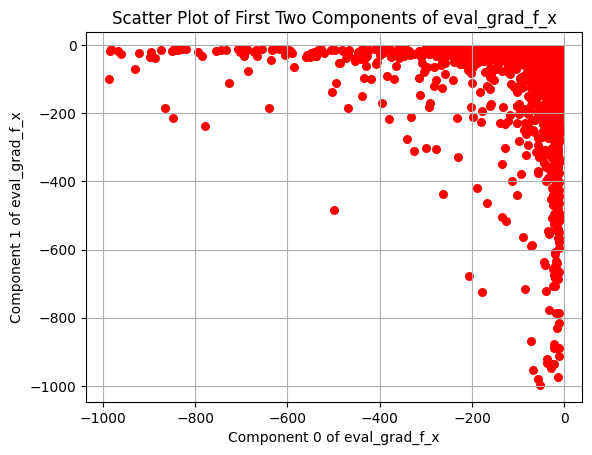

Residual along axis 0 @ value = -505.0: 59.091888427734375


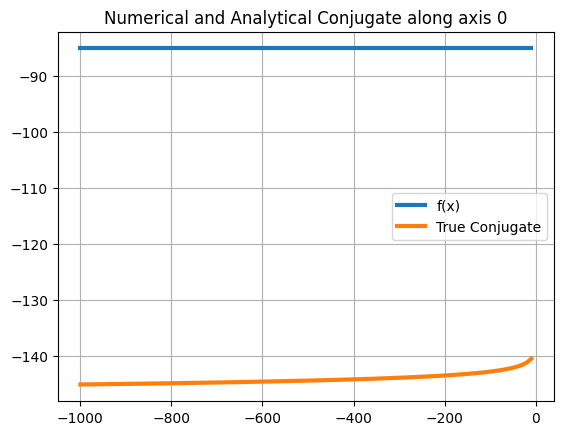

Residual along axis 1 @ value = -505.0: 59.091888427734375


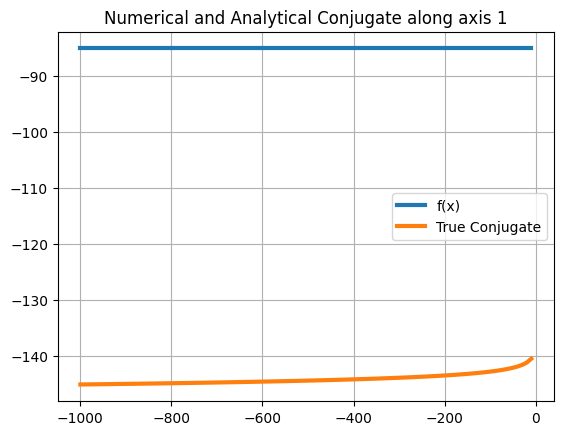

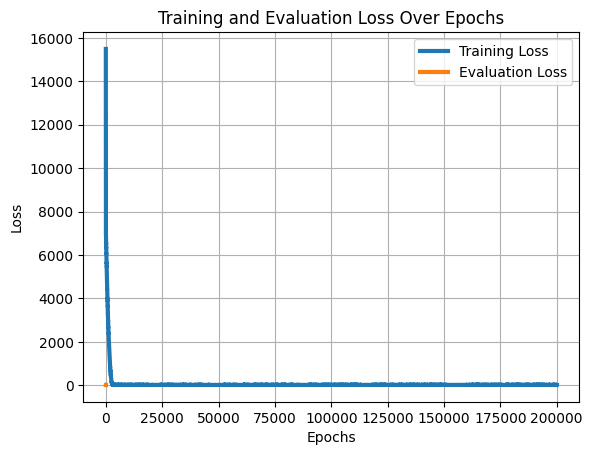

-1000 -10


In [ ]:
const_val = (minval + maxval)/2

plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_losses, eval_losses)

print(minval, maxval)

In [ ]:
# loss_list = [float(value) for value in Loss]

# # Print the result
# print(loss_list)

In [ ]:
# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(train_x)
# preds = jnp.squeeze(state.apply_fn({'params': state.params}, eval_grad_f_x)).reshape(-1, 1)
# accuracy,acc_max, residual, mre = calculate_statistics(eval_batch_x, eval_grad_f_x, preds, vmap_f_star_true,  train_loss_list, eval_loss_list)
# print("Accuracy:", accuracy)
# print("Accuracy max norm:", acc_max)
# print("Accuracy, rel:", mre)
# print("Residual:", residual)


# Find the statistics corresponding to the best RMSE
best_stat = min(statistics_list, key=lambda x: x['best_rmse'])

# Print the best statistics
print("\nBest Evaluation Results:")
print(f"\nEvaluation after {best_stat['epoch']} epochs:")
print(f"Train Loss = {best_stat['train_loss']:.6f}")
print(f"Eval Loss = {best_stat['eval_loss']:.6f}")
print(f"Best RMSE = {best_stat['best_rmse']:.6f} at epoch {best_stat['best_epoch']}")



Best Evaluation Results:

Evaluation after 199998 epochs:
Train Loss = 15.745481
Eval Loss = 15.164242
Best RMSE = 3.894129 at epoch 199998
Total Runtime = 0:12:24.908952

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.8941290378570557, Max Accuracy = 18.049118041992188, RMSE = 3.894129, Mean Relative Error = 0.036660

Measure 'nu' results
Accuracy (y_nu) = 54.05718231201172, Max Accuracy (y_nu) = 65.36265563964844, Mean Relative Error (y_nu) = 0.387262
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results

### RESULTS FOR THE DLT PAPER:

* d = 20
* L2 Accuracy =   3.8941290378570557  (direct sampling)
* L-2 Accuracy (y_nu) =  54.05718231201172, (target uniform measure)
* Runtime:

Train the best example Runtime = 12:24

Total runtime for 200k itereations = 12:24